## Prepare Trial Data from Vicon

> Duncan Bakke<br>
> Converted into Python by Alex Woodall<br>
> Auckland Bioengineering Institute<br>
> Auckland, New Zealand

This notebook conditions and collates trial data, and setups all necessary OpenSim analysis xmls.

_Note:_ This is written in Python 3.7.4 with OpenSim 4.0. Make sure you have read the [Python 3 OpenSim API Setup](OpenSim4.0Python3API.ipynb) and testing that the OpenSim API is working with Python 3.

__Assuming that the motion capture data was pre-processed in Nexus to remove gaps and duplicate markers.__<br>
__Assuming that in the input directory, there is at least a trc and mot file of the trial.__<br>
__Assuming that the OpenSim model has already been pre-scaled and the model.osim and modelMarkerSet.xml is sitting in the model output directory (output_directory > model).__

The code in this notebook can also be used as a function call.

Start by importing the necessary libraries

In [23]:
import os
import sys

import tkinter as tk
from tkinter import filedialog

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib notebook

sys.path.insert(1, r'Functions')  # add to path

from read_trc import read_trc
from write_trc import write_trc
from trim_trc import trim_trc

from read_mot import read_mot
from write_mot import write_mot

from remove_bad_markers import remove_bad_markers
from rezero_filter import rezero_filter
from fix_grf_headers import fix_grf_headers

from xml_shorten import xml_shorten

from setup_muscle_force_direction_xml import setup_muscle_force_direction_xml

# OpenSim API
from setup_ID_xml import setup_ID_xml
from setup_IK_xml import setup_IK_xml
from setup_load_xml import setup_load_xml
from setup_muscle_analysis_xml import setup_muscle_analysis_xml

## Requirements

We require the directories of the output, input, and setup xmls as well as the model name and trial name.

In [14]:
root = tk.Tk()
root.withdraw()

# Let the user select the directories
input_directory = filedialog.askdirectory(initialdir = os.getcwd(),title = "Select INPUT directory")
output_directory = filedialog.askdirectory(initialdir = os.getcwd(),title = "Select OUTPUT directory")
xml_directory = filedialog.askdirectory(initialdir = os.getcwd(),title = "Select TEMPLATE XML directory")

# Enter model and trial names - should be the names on the input files
model = 'AB08'
trial = '_12Mar_ss_12ms_01'

## Intial Setup/names

In [16]:
# List which contains the names of the motion capture trials which didn't record EMG data. Add to this list if necessary
bad_EMG_trials = ['SAFIST015_SS21_20Jun_ss_035ms_02','SAFIST015_SS21_20Jun_fast_075ms_02',
                  'SAFIST015_SS42_20Jun_ss_035ms_01','SAFIST015_SS42_20Jun_fast_055ms_01','SAFIST015_SS52_ss_04ms_02',
                  'SAFIST015_SS52_fast_07ms_01','SS77_SAFIST015_18Jun_fast_04ms_02','SAFIST015_19Jun_SS90_ss_035ms_01',
                  'SAFIST015_19Jun_SS90_fast_055ms_01','_12Mar_ss_12ms_01']

bad_EMG = 0 # Set bad_EMG flag to 0 (trial contains good EMG data)
recalculate_COP = 1 # Do you want to recalcuate the COP (recommended)

# Check if the trial you are running is in the list of bad EMG trials
if any(trial == s in s for s in bad_EMG_trials):
    bad_EMG = 1 # Set bad_EMG flag to 1 (trial does not contain good EMG data)
    
# Identify files from Vicon/Nexus export to read
trc_filename = os.path.join(input_directory, trial + "." + "trc")
mot_filename = os.path.join(input_directory, trial + "." + "mot")
emg_filename = os.path.join(input_directory, trial + "_EMG." + "mot")

# Check if the trc/mot/emg files do not exist, and try a different name if they don't
if not os.path.exists(trc_filename):
    trc_filename = os.path.join(input_directory, model + trial + "." + "trc")

if not os.path.exists(mot_filename):
    mot_filename = os.path.join(input_directory, model + trial + "." + "mot")

if not os.path.exists(emg_filename):
    print('No EMG data for subject %s.\n' % (model))
    bad_EMG = 1
    
# Make new folder for the output of this model if it doesn't already exist
output_model_dir = os.path.join(output_directory, model)
output_model_trial_dir = os.path.join(output_model_dir, trial)

if not os.path.exists(output_model_dir):
    os.mkdir(output_model_dir)
    print("Making new ouput model directory")

if not os.path.exists(output_model_trial_dir):
    os.mkdir(output_model_trial_dir)
    print("Making new output model trial directory")
    
# Generate filenames for template xml files
IK_filename = os.path.join(xml_directory, "IKSetup.xml")
ID_filename = os.path.join(xml_directory, "IDSetup.xml")
ex_loads_filename = os.path.join(xml_directory, "ExternalLoads.xml")
muscle_analysis_filename = os.path.join(xml_directory, "MuscleAnalysisSetup.xml")
muscle_force_direction_filename = os.path.join(xml_directory, "MuscleForceDirectionSetup.xml")

No EMG data for subject AB08.



## Pull in exported Vicon files, identify time range of interest

This approach differs with regard to available event data

In [18]:
# Read the trc file
mkr_data, _ = read_trc(trc_filename)

# Pull out the data of interest
frames = mkr_data["Data"]["FrameNums"]
time = mkr_data["Data"]["Time"]
data_rate = mkr_data["Information"]["DataRate"]
markers = mkr_data["Data"]["Markers"]
marker_names = mkr_data["Data"]["ModifiedMarkerLabels"]

print(model)
print(trial)
print('\n')

if not bad_EMG:
    #TODO, waiting for EMG data file
    pass

# 8 refers to the first line of data in the motion file (not in Python indexing e.g., 8 = line 8 (not line 9))
grf_headers, full_grf_data = read_mot(8, mot_filename)

if ('SS' in model) or ('AB' in model): # If SS or AB, recorded at AUT Millenium
    steps = ['l', 'r']
    plates = [1, 2]

# Create time range
time_range = []

time_range.append(round(max(time[0], 0) + 0.020, 3))
time_range.append(time[-1])

index_start = np.where(time == time_range[0])
index_end = np.where(time == time_range[1])

# Create frame range
frame_range = []

frame_range.append(frames[index_start]) 
frame_range.append(frames[index_end])

AB08
_12Mar_ss_12ms_01




## Inverse Kinematics Setup

In [19]:
# Trim data to be within the start and end indices
trimmed_markers, trimmed_frames, trimmed_time = trim_trc(markers, frames, time, [int(index_start[0]), int(index_end[0])])

# Remove bad markers may not be needed, as conditioning done in Nexus - bad_marker_names is not used
good_markers, good_marker_names, bad_marker_names = remove_bad_markers(trimmed_markers, marker_names)

# Convert good_markers into an ndarray (nframes x nmarkers * 3)
marker_data = []

for keys in good_markers.keys():
    marker_data.append(good_markers[keys]["All"])

marker_data = np.array(marker_data).transpose(1,0,2).reshape(len(trimmed_frames),-1)

# Concatenate marker data with frame numbers and times
new_mkr_data = np.concatenate((trimmed_frames[:, np.newaxis], trimmed_time[:, np.newaxis], marker_data),axis=1)

new_filename = os.path.join(output_model_trial_dir, trial + "." + "trc")

# Edit mkr_data["Information"] for trimmed dataset
mkr_data["Information"]["NumFrames"] = len(trimmed_frames)
mkr_data["Information"]["NumMarkers"] = np.size(good_marker_names)

write_trc(good_marker_names, mkr_data["Information"], trimmed_frames, new_mkr_data, new_filename)

# Create the IK setup xml file using the OpenSim API
setup_IK_xml(IK_filename, trial, model, output_directory, time_range, good_marker_names)

# Because minidom was used at the end of creating the IK file, we need to remove the extra white space that was created
filename = output_directory + "\\" + model + "\\" + trial + "\\" + trial + IK_filename.split("\\")[-1]
xml_shorten(filename)

New TRC location: C:/Users/alexw/Dropbox/ABI/Level_8_Lab/OpenSim Tools/ProcessingTrialDataFromVicon/Output\AB08\_12Mar_ss_12ms_01\_12Mar_ss_12ms_01.trc



## Inverse Dynamics Setup

<IPython.core.display.Javascript object>


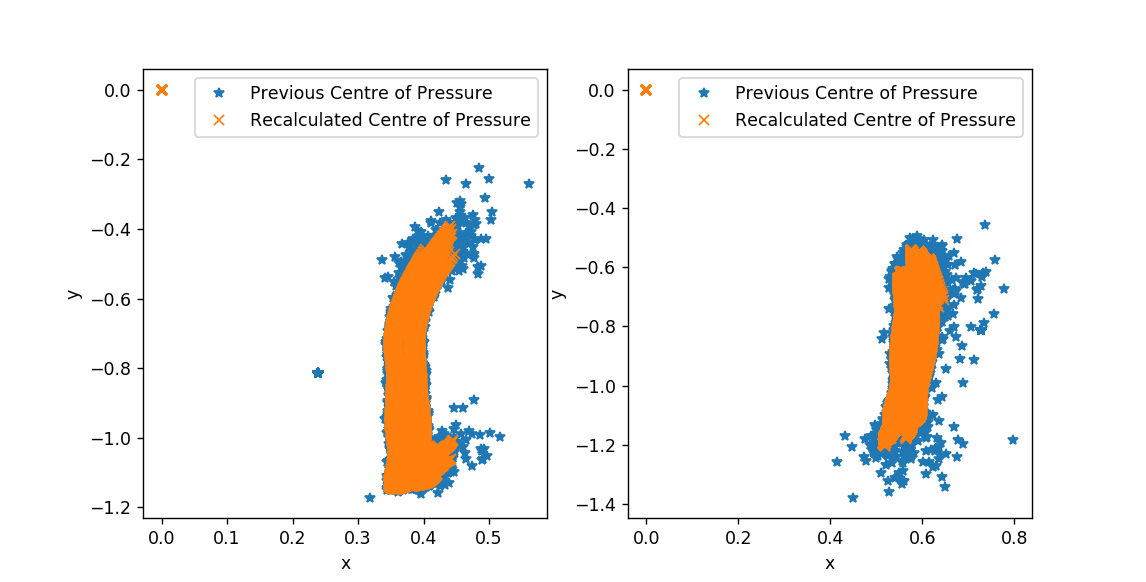

In [32]:
''' ID files '''

# Define the grf capture rate
grf_rate = (len(full_grf_data) - 1) / (full_grf_data[-1,0] - full_grf_data[0,0])

# Get the original vertical forces
indices = [i for i, s in enumerate(grf_headers) if 'vy' in s]
original_fy = full_grf_data[:,indices]

# Filter GRF data
cut_off_frequency = 10
Wn = cut_off_frequency/(grf_rate/2)

# Describe filter characteristics using 4th order Butterworth filter
b, a = signal.butter(4, Wn)

new_grf_data = np.zeros(np.shape(full_grf_data))
new_grf_data[:,0] = full_grf_data[:,0] # Not filtering time data

for i in range(1,len(grf_headers)):
    new_grf_data[:,i] = signal.filtfilt(b, a, full_grf_data[:,i], axis=0)

# Re-zero grfs
filter_plate = rezero_filter(original_fy)

# Re-zero all columns except those which refer to the centre of pressure
# Assumes that the only headers which contain 'p' are CoP

for i in range(1,len(grf_headers)): # Are not rezeroing time
    # If not centre of pressure AND force plate 1
    if ('p' not in grf_headers[i]) and ('1' in grf_headers[i]):
        new_grf_data[:,i] = filter_plate[:,0] * new_grf_data[:,i]
    # If not centre of pressure AND force plate 2
    elif ('p' not in grf_headers[i]) and ('2' in grf_headers[i]):
        new_grf_data[:,i] = filter_plate[:,1] * new_grf_data[:,i]

if recalculate_COP:
    # Define for recalculating CoP - position of force plates
    x_offset = [0.2385, 0.7275]
    y_offset = [0, 0]

    # OpenSim Coordinate frame has y upwards. We will convert to x and y being the plane parallel
    # the ground for convenience (will return to OpenSim coordinates when creating new grf data)
    vz_inds = [i for i, s in enumerate(grf_headers) if 'vy' in s]
    px_inds = [i for i, s in enumerate(grf_headers) if 'px' in s]
    py_inds = [i for i, s in enumerate(grf_headers) if 'pz' in s]

    fZ = np.zeros(np.shape(filter_plate.T))
    pX = np.zeros(np.shape(filter_plate.T))
    pY = np.zeros(np.shape(filter_plate.T))
    oldmY = np.zeros(np.shape(filter_plate.T))
    oldmX = np.zeros(np.shape(filter_plate.T))

    # Back calculate moment measurements
    for i in range(len(plates)):
        side_inds = [j for j, s in enumerate(grf_headers) if str(i+1) in s]

        fZ[i,:] = full_grf_data[:,list(set(side_inds).intersection(vz_inds))].T
        pX[i,:] = full_grf_data[:,list(set(side_inds).intersection(px_inds))].T
        pY[i,:] = full_grf_data[:,list(set(side_inds).intersection(py_inds))].T

        oldmX[i,:] = (y_offset[i] + pY[i,:]) * fZ[i,:]
        oldmY[i,:] = (x_offset[i] - pX[i,:]) * fZ[i,:]

    # Filter old moments
    mX = signal.filtfilt(b, a, oldmX, axis=1)
    mY = signal.filtfilt(b, a, oldmY, axis=1)

    # Rezero moments
    for i in range(len(plates)):
        mX[i,:] = filter_plate[:,i].T * mX[i,:]
        mY[i,:] = filter_plate[:,i].T * mY[i,:]

    # Recalculate CoP with filtered forces and moments
    new_pX = np.zeros(np.shape(pX))
    new_pY = np.zeros(np.shape(pY))

    for i in range(len(plates)):
        side_inds = [j for j, s in enumerate(grf_headers) if str(i+1) in s]
        new_fZ = new_grf_data[:, list(set(side_inds).intersection(vz_inds))]

        for j in range(len(mY[i,:])):
            if new_fZ[j] != 0:
                new_pX[i,j] = x_offset[i] - (mY[i,j] / new_fZ[j])
                new_pY[i,j] = y_offset[i] + (mX[i,j] / new_fZ[j])
            else:
                new_pX[i,j] = 0
                new_pY[i,j] = 0

        new_grf_data[:, list(set(side_inds).intersection(px_inds))] = new_pX[i,:][:,np.newaxis]
        new_grf_data[:, list(set(side_inds).intersection(py_inds))] = new_pY[i,:][:, np.newaxis]

        plt.subplot(1,2,i+1)
        plt.plot(pX[i,:], pY[i,:], '*', label='Previous Centre of Pressure')
        plt.plot(new_pX[i,:], new_pY[i,:], 'x', label='Recalculated Centre of Pressure')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()

    plt.show()

In [33]:
# Trim the new grf data to within the time range
grf_data = new_grf_data[int(np.where(np.float32(new_grf_data[:,0]) == time_range[0])[0]):int(np.where(np.float32(new_grf_data[:,0]) == time_range[-1])[0] + 1), :]

# Change headers
new_headers = fix_grf_headers(grf_headers, steps, plates)

# Write force data to a motion file
new_filename = os.path.join(output_model_trial_dir, trial + "." + "mot")
write_mot(grf_data, new_filename, new_headers)

# Create the ID setup xml file using the OpenSim API
setup_ID_xml(ID_filename, trial, model, output_directory, time_range, cut_off_frequency)

# Create the external load setup xml file using the OpenSim API
setup_load_xml(ex_loads_filename, trial, model, output_directory, cut_off_frequency)

New MOT location: C:/Users/alexw/Dropbox/ABI/Level_8_Lab/OpenSim Tools/ProcessingTrialDataFromVicon/Output\AB08\_12Mar_ss_12ms_01\_12Mar_ss_12ms_01.mot


## EMG Processing

In [34]:
# TODO
pass

## Muscle Analysis Files

In [35]:
# Create muscle analysis xml file using the OpenSim API
setup_muscle_analysis_xml(muscle_analysis_filename, trial, model, output_directory, time_range, cut_off_frequency)

# Create muscle force direction xml file (currently does not use OpenSim API)
setup_muscle_force_direction_xml(muscle_force_direction_filename, trial, model, output_directory, time_range, cut_off_frequency)
filename = output_directory + "\\" + model + "\\" + trial + "\\" + trial + muscle_force_direction_filename.split("\\")[-1]
xml_shorten(filename)